In [1]:
import so3g 
from spt3g import maps
from spt3g import core
from spt3g.core import G3Units as gu
from astropy.coordinates import EarthLocation
import numpy as np
import matplotlib.pyplot as plt
import pathlib
import g3_utils as ut

In [2]:
control_computer_g3_dir = pathlib.Path("/media/player1/blast2020fc1/blasttng_g3")
roach1_pass3_file = control_computer_g3_dir / "testing/roach1_pass3.g3"

ra_df_added = control_computer_g3_dir / "mapmaking/ra_df_added.g3"
norm_df_added = control_computer_g3_dir / "mapmaking/norm_df_added.g3"

In [66]:
def ang_to_quat_fixed(alpha, delta, start=None, stop=None):
    """
    Copied & fixed since maps.ang_to_quat has a missing return statement
    
    Convert a set of angles (or vector of them) specified as a (longitude,
    latitude) pair to a pointing quaternion (or vector of them). If start
    and stop are defined, the return value for vectors will be a
    G3TimestreamQuat with start and stop times set to the provided values.
    """

    alpha = np.asarray(alpha) / gu.rad
    delta = np.asarray(delta) / gu.rad
    # Copied from C code
    c_delta = np.cos(delta)
    q = np.column_stack(
        (
            0 * c_delta,  # 0s with the right shape
            c_delta * np.cos(alpha),
            c_delta * np.sin(alpha),
            np.sin(delta),
        )
    )

    if len(q) == 1:
        return core.quat(q[0, :])
    else:
        if start is not None:
            out = core.G3TimestreamQuat(q)
            out.start = start
            out.stop = stop
            return out
        else:
            return core.G3VectorQuat(q)

In [121]:
def radec_to_quats(frame, ra="ra", dec="dec", out_key="pointing"):
    if frame.type != core.G3FrameType.Scan:
        return
    quat_ts = ang_to_quat_fixed(
        frame[ra], frame[dec], start=frame[ra].start, stop=frame[ra].stop
    )
    ra1, dec1 = maps.quat_to_ang(quat_ts[0])
    print(ra1/gu.deg + 360, dec1/gu.deg)
    frame[out_key] = quat_ts

In [122]:
def superts_to_tsmap(frame, in_key="", out_key="", frame_type=None):
    frame_type = frame_type if frame_type is not None else core.G3FrameType.Scan
    if frame.type != frame_type:
        return
    super_ts = frame[in_key]
    frame[out_key] = core.G3TimestreamMap(super_ts.names, super_ts.data, super_ts.times[0], super_ts.times[-1])

In [230]:
# center of the sky map
ra0 = 231.15 * core.G3Units.deg
dec0 = -56.2 * core.G3Units.deg

ra_test = -201.5 * core.G3Units.deg
dec_test = 35.5 * core.G3Units.deg

xlen = 100
ylen = 100

# pixel resolution
res = 1 * core.G3Units.arcmin

smstub = maps.FlatSkyMap(
    xlen, ylen, res,
    proj=maps.MapProjection.ProjLambertAzimuthalEqualArea,
    alpha_center=ra_test, delta_center=dec_test,
    # x_center=0, y_center=0
)

map_frame_grabber = ut.NthFrameGrabber(2, core.G3FrameType.Map)

pipe = core.G3Pipeline()
pipe.Add(core.G3Reader, filename=str(norm_df_added))
pipe.Add(radec_to_quats)
pipe.Add(superts_to_tsmap, in_key="norm_df", out_key="norm_df_map")
pipe.Add(
    maps.SingleDetectorBoresightBinner,
    stub_map=smstub,
    timestreams='norm_df_map',
    pointing='pointing',
)
pipe.Add(map_frame_grabber)
pipe.Add(ut.FrameCounter)
pipe.Run()

first_map_frame = map_frame_grabber.nth_frame
print("First map frame: ", first_map_frame)
print("FlatSkyMap: ", first_map_frame["T"])


Calibration
230.93729730808505 -55.90417946585062

231.44616695726086 -56.01788031999741
231.90906512431286 -56.12932297282186
231.67583189016509 -56.084526326883804
231.0800665502176 -55.96310119333846
231.10170859138867 -55.970605165448156
231.61507570910902 -56.099135144480556
231.9392332052833 -56.178153752982254
231.38874100444042 -56.06125556153791
230.88322749306315 -55.95518371345343
231.2991031762462 -56.05599407607904
231.76752588855922 -56.18113732884323
231.74767002211107 -56.192833664530596
231.1398719659203 -56.060741650731124
230.93111720978393 -56.00959836124991
231.46665948023193 -56.13003507413214
231.90386543280417 -56.22863442419353
231.4885407210975 -56.13968802069319
230.92563977427204 -56.01380420328387
231.14305424508754 -56.07475179114895
231.6443859460449 -56.195858171247835
231.82425926819707 -56.245930119796505
231.22331304689806 -56.114212574884874
230.84553021501804 -56.02333387714378
231.35476426668652 -56.144277313762174
231.82500703054507 -56.250820479

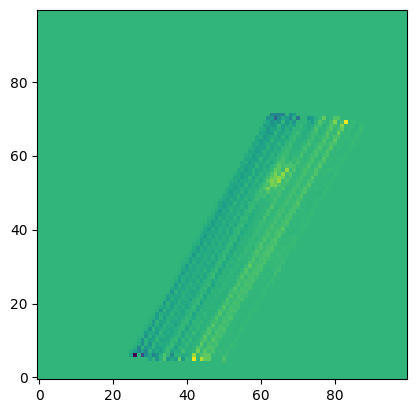

In [239]:
im = np.asarray(first_map_frame["T"])
plt.imshow(im, origin='lower')
plt.show()

In [232]:
max_indices = np.unravel_index(np.argmax(im), im.shape)
print(max_indices[1]-179.5, max_indices[0]-179.5)

-96.5 -110.5


In [135]:
first_map_frame["T"][97813]

0.0

In [99]:
q = maps.ang_to_quat(ra0, dec0)
ra1, dec1 = maps.quat_to_ang(q)
print(ra0, ra1)
print(dec0, dec1)

4.034328565984893 -2.2488567411946936
-0.9808750396208132 -0.9808750396208133


In [95]:
-2.2488564502060693/gu.deg, 

-128.84998332757993